In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from admm.agents import Fed
from admm.servers import FedAgg
from admm.models import FCNet
from admm.utils import average_params
from admm.data import partition_data, split_dataset
import seaborn as sns
sns.set_theme()

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Lambda(lambda x: torch.flatten(x))
])

mnist_trainset = datasets.MNIST(
    root='./data/mnist_data', train=True,
    download=True, transform=mnist_transform, 
)
mnist_testset = datasets.MNIST(
    root='./data/mnist_data', train=False,
    download=True, transform=mnist_transform
)

train_dataset, val_dataset, _ = split_dataset(dataset=mnist_trainset, train_ratio=0.8, val_ratio=0.2)

trainsets = partition_data(
    num_clients=100,
    iid=False,
    balance=True,
    power_law=False,
    seed=42,
    trainset=train_dataset.dataset,
    labels_per_partition=1
)

for i, dataset in enumerate(trainsets):
    labels = np.zeros(10)
    dummy_loader = DataLoader(dataset, batch_size=1)
    for data, target in dummy_loader:
        labels[target.item()] += 1
    print(f'Dataset {i} distribution: {labels} - num_samples = {labels.sum()}')

labels = np.zeros(10)
dummy_loader = DataLoader(val_dataset, batch_size=1)
for data, target in dummy_loader:
    labels[target.item()] += 1
print(f'Validation dataset {i} distribution: {labels} - num_samples = {labels.sum()}')

labels = np.zeros(10)
dummy_loader = DataLoader(mnist_testset, batch_size=1)
for data, target in dummy_loader:
    labels[target.item()] += 1
print(f'Validation dataset {i} distribution: {labels} - num_samples = {labels.sum()}')

batch_size = 28
train_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in trainsets]
test_loader = DataLoader(mnist_testset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=True)

Dataset 0 distribution: [  0.   0. 271.   0.   0.   0.   0. 271.   0.   0.] - num_samples = 542.0
Dataset 1 distribution: [  0.   0.   0. 271.   0.   0.   0.   0.   0. 271.] - num_samples = 542.0
Dataset 2 distribution: [  0.   0. 542.   0.   0.   0.   0.   0.   0.   0.] - num_samples = 542.0
Dataset 3 distribution: [271.   0.   0. 271.   0.   0.   0.   0.   0.   0.] - num_samples = 542.0
Dataset 4 distribution: [  0.   0. 271.   0.   0.   0.   0.   0. 271.   0.] - num_samples = 542.0
Dataset 5 distribution: [  0.   0.   0.   0. 271. 271.   0.   0.   0.   0.] - num_samples = 542.0
Dataset 6 distribution: [  0.   0. 271.   0.   0.   0.   0.   0. 271.   0.] - num_samples = 542.0
Dataset 7 distribution: [  0.   0.   0. 271.   0.   0.   0. 271.   0.   0.] - num_samples = 542.0
Dataset 8 distribution: [  0.   0.   0.   0.   0.   0.   0.   0. 271. 271.] - num_samples = 542.0
Dataset 9 distribution: [  0.   0.   0.   0. 271. 271.   0.   0.   0.   0.] - num_samples = 542.0
Dataset 10 distribut

In [3]:
lr = 0.001
rho = 0.01
t_max = 100
loaders = train_loaders
device = 'cpu'
rates = np.arange(start=0.1, stop=1.1, step=0.1)
print(rates)
agents = []

acc_per_rate = np.zeros((len(rates), t_max))
rate_per_rate = np.zeros((len(rates), t_max))
loads = []
test_accs = []

for i, rate in enumerate(rates):
    for loader in loaders:
        torch.manual_seed(78)
        model = FCNet(in_channels=784, hidden1=200, hidden2=None, out_channels=10)
        agents.append(
            Fed(
                loss=nn.CrossEntropyLoss(),
                model=model,
                train_loader=loader,
                epochs=1,
                device=device,
                lr=lr
            )
        )

    server = FedAgg(
        clients=agents, 
        t_max=t_max, 
        model=FCNet(in_channels=784, hidden1=200, hidden2=None, out_channels=10), 
        device=device,
        C=rate
    )

    server.spin(loader=val_loader)
    
    acc_per_rate[i,:] = server.val_accs
    rate_per_rate[i,:] = server.rates
    load = sum(rate_per_rate[i,:])/t_max
    acc = server.validate_global(loader=test_loader)
    print(f'Test accuracy for rate {rate} = {acc}')
    loads.append(load)
    test_accs.append(acc)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Comm: 0.100, Global Acc = 0.8767: 100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


Test accuracy for rate 0.1 = 0.8707000017166138


Comm: 0.200, Global Acc = 0.9219: 100%|██████████| 100/100 [04:09<00:00,  2.49s/it]


Test accuracy for rate 0.2 = 0.9218999743461609


Comm: 0.300, Global Acc = 0.8867: 100%|██████████| 100/100 [08:09<00:00,  4.89s/it]


Test accuracy for rate 0.30000000000000004 = 0.8859999775886536


Comm: 0.400, Global Acc = 0.8896: 100%|██████████| 100/100 [13:30<00:00,  8.10s/it]


Test accuracy for rate 0.4 = 0.888700008392334


Comm: 0.500, Global Acc = 0.8758: 100%|██████████| 100/100 [20:40<00:00, 12.40s/it]


Test accuracy for rate 0.5 = 0.8756999969482422


Comm: 0.600, Global Acc = 0.8942: 100%|██████████| 100/100 [29:14<00:00, 17.55s/it]


Test accuracy for rate 0.6 = 0.8913000226020813


Comm: 0.700, Global Acc = 0.9024: 100%|██████████| 100/100 [1:17:04<00:00, 46.25s/it]


Test accuracy for rate 0.7000000000000001 = 0.8989999890327454


Comm: 0.800, Global Acc = 0.9068: 100%|██████████| 100/100 [51:07<00:00, 30.67s/it]


Test accuracy for rate 0.8 = 0.9054999947547913


Comm: 0.900, Global Acc = 0.9053: 100%|██████████| 100/100 [1:04:45<00:00, 38.86s/it]


Test accuracy for rate 0.9 = 0.9010000228881836


Comm: 1.000, Global Acc = 0.9087: 100%|██████████| 100/100 [1:19:39<00:00, 47.80s/it]


Test accuracy for rate 1.0 = 0.9049999713897705


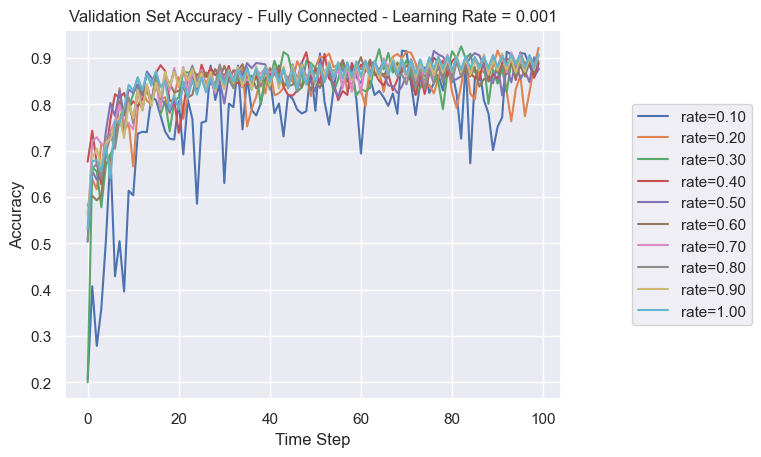

In [5]:
T = range(t_max)
# Plot accuracies
for acc, rate in zip(acc_per_rate, rates):
    plt.plot(T, acc, label=f'rate={rate:.2f}')
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Accuracy')
plt.title('Validation Set Accuracy - Fully Connected - Learning Rate = 0.001')
plt.savefig('./images/mnist/FedAVG/fc_val.png')
plt.show()

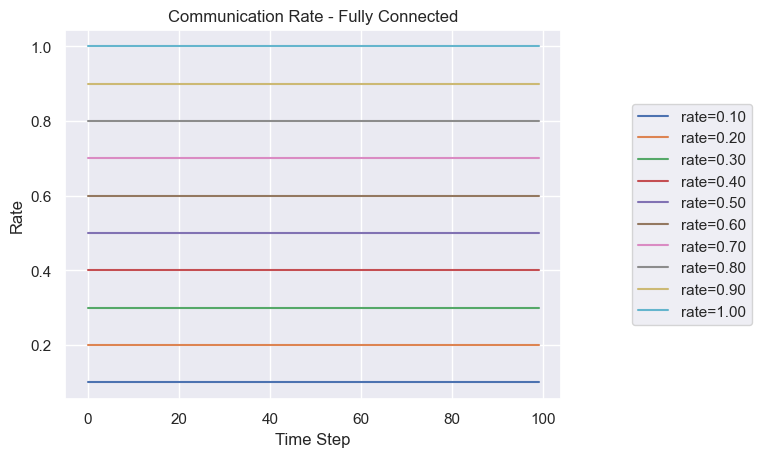

In [7]:
for rate, r in zip(rate_per_rate, rates):
    plt.plot(T, rate, label=f'rate={r:.2f}')
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Rate')
plt.title('Communication Rate - Fully Connected')
plt.savefig('./images/mnist/FedAVG/fc_comm_rate.png')
plt.show()

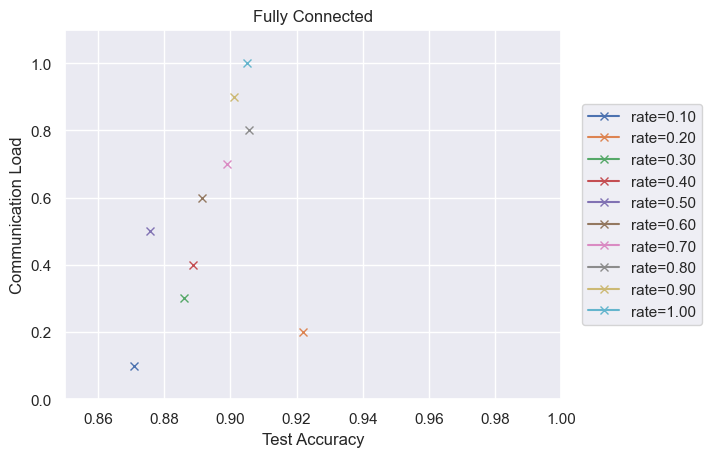

In [9]:
for load, acc, rate in zip(loads, test_accs, rates):
    plt.plot(acc, load, label=f'rate={rate:.2f}', marker='x')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Test Accuracy')
plt.xlim([0.85, 1])
plt.ylim([0,1.1])
plt.ylabel('Communication Load')
plt.title('Fully Connected')
plt.savefig('./images/mnist/FedAVG/fc_test_load.png')
plt.show()

In [ ]:
np.save(file='figure_data/FedAVG/mnist/rates_per_delta', arr=rate_per_rate)
np.save(file='figure_data/FedAVG/mnist/accs_per_delta', arr=acc_per_rate)
np.save(file='figure_data/FedAVG/mnist/loads_per_delta', arr=loads)
np.save(file='figure_data/FedAVG/mnist/deltas', arr=rates)